In [432]:
import astroprov
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table, vstack
from astropy.table import Column

import collections
import subprocess
from astropy.io import ascii
import time
from astropy.utils.data import clear_download_cache
from astroquery.gaia import Gaia
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [433]:
clear_download_cache()

In [434]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print(table.get_qualified_name())

Retrieving tables...
Parsing tables...
Done.
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighb

In [3]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [4]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)

In [169]:
def queryObjectRegion(outputTable,searchRadius=5*u.arcsecond):
    imageCoords = []
    r = searchRadius
    
#     if inCat == 'dao':
#         xlabel = 'xcentroid'
#         ylabel = 'ycentroid'
#         label = 'id'
        
#     if inCat == 'sex':
#         xlabel = 'X_IMAGE'
#         ylabel = 'Y_IMAGE'
#         label = 'NUMBER'
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    magnitudes = outputTable['MAG_BEST_ORIG']
    magdiff = outputTable['magDiff']
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['IMAGE_NAME']
    dates = [x[x.index('kplr')+len('kplr'):x.index('_')] for x in imageNames]
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype','coo_bibcode')
    customSimbad.remove_votable_fields('coordinates')
    #customSimbad.add_votable_fields('bibcodelist')      
    result_table = Table([['-'],[0],[0],['-'],['-'],[0],[0],[0],[0],[0],['-'],['-'],['-']],names=('MAIN_ID','RA_d','DEC_d','OTYPE','bibcode','Xcentroid','Ycentroid','Flux','SExtractor Mag','Mag Increase','IMAGE','Index','yyyydddhhss'),dtype=('object','float64','float64','object','object','float64','float64','float64','float64','float64','object','object','object'))


    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            print(rt)
            
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            rowlist.append(flux[x])
            rowlist.append(magnitudes[x])
            rowlist.append(magdiff[x])
            rowlist.append(imageNames[x])
            rowlist.append(x)
            rowlist.append(dates[x])
            result_table.add_row(rowlist)

        except:
            #print('searchfailed')
            result_table.add_row(['N/A',ra[x],dec[x],'Object Not Found','--',[imageCoords[x][0]],[imageCoords[x][1]],flux[x],magnitudes[x],magdiff[x],imageNames[x],x,dates[x]])

    
    return result_table

In [170]:
smallsim = queryObjectRegion(otherGaiaTab)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
  MAIN_ID        RA_d        DEC_d       OTYPE       COO_BIBCODE    
                 deg          deg                                   
------------ ------------ ------------ --------- -------------------
V* V1504 Cyg 292.23521350  43.09363262 DwarfNova 2018yCat.1345....0G
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
  MAIN_ID        RA_d        DEC_d       OTYPE       COO_BIBCODE    
                 deg          deg                                   
-----------

None
None
  MAIN_ID        RA_d        DEC_d     OTYPE     COO_BIBCODE    
                 deg          deg                               
------------ ------------ ------------ ----- -------------------
V* V1119 Cyg 291.43575835  51.15877203  Mira 2018yCat.1345....0G
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
  MAIN_ID       RA_d        DEC_d       OTYPE       COO_BIBCODE    
                deg          deg                                   
----------- ------------ ------------ --------- -------------------
V* V344 Lyr 281.16322866  43.37445875 DwarfNova 2018yCat.1345....0G
None
None
None
  MAIN_ID        RA_d        DEC_d     OTYPE     COO_BIBCODE    
                 deg          deg                               
------------ ------------ ------------ ----- -------------------
V* V1119 Cyg 291.43575835  51.15877203  Mira 2018yCat.1345....0G
None
None
None
None
None
None
None
None
  MAIN_ID        RA_d        DEC_

In [171]:
smallsim

MAIN_ID,RA_d,DEC_d,OTYPE,bibcode,Xcentroid,Ycentroid,Flux,SExtractor Mag,Mag Increase,IMAGE,Index,yyyydddhhss
object,float64,float64,object,object,float64,float64,float64,float64,float64,object,object,object
-,0.0,0.0,-,-,0.0,0.0,0.0,0.0,0.0,-,-,-
N/A,285.3085242660774,38.64320337442705,Object Not Found,--,817.5698,251.1989,3081.252,16.1003,-2.051571026739004,kplr2009114174833_ffi-cal.fits[12],0,2009114174833
N/A,283.4488845006899,46.91229413625908,Object Not Found,--,977.2311,335.0007,1563.474,16.9888,-4.065613299233601,kplr2009114174833_ffi-cal.fits[13],1,2009114174833
N/A,281.2626986253877,48.092472568384956,Object Not Found,--,881.0323,160.3248,1447.371,16.9315,-2.114461736361008,kplr2009114174833_ffi-cal.fits[15],2,2009114174833
N/A,282.4562432093736,48.71368743412436,Object Not Found,--,433.0373,179.9004,1633.5,16.776,-1.9795994886337922,kplr2009114174833_ffi-cal.fits[16],3,2009114174833
N/A,284.5588528253113,44.51322961355488,Object Not Found,--,804.2537,448.7743,2189.427,16.2405,-1.2588115646345834,kplr2009114174833_ffi-cal.fits[19],4,2009114174833
N/A,285.02991137598053,43.780980764606234,Object Not Found,--,91.0074,292.5105,2139.691,16.1544,-1.049369785748642,kplr2009114174833_ffi-cal.fits[19],5,2009114174833
N/A,288.4724636796787,43.80081740402751,Object Not Found,--,849.4122,32.2863,14608.01,14.4266,-2.1459148315518672,kplr2009114174833_ffi-cal.fits[21],6,2009114174833
N/A,287.4616317565798,43.91652339662211,Object Not Found,--,386.4077,513.6817,8640.346,14.8043,-1.3879303146710897,kplr2009114174833_ffi-cal.fits[21],7,2009114174833


In [172]:
#smallsim
df = smallsim.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,OTYPE,bibcode,Xcentroid,Ycentroid,Flux,SExtractor Mag,Mag Increase,IMAGE,Index,yyyydddhhss
0,-,0.000000,0.000000,-,-,0.0000,0.0000,0.000,0.0000,0.000000,-,-,-
96,V* V1504 Cyg,292.235214,43.093633,DwarfNova,2018yCat.1345....0G,933.8094,121.8330,28890.030,13.3526,-1.090021,kplr2009115080620_ffi-cal.fits[46],95,2009115080620
117,V* V1504 Cyg,292.235214,43.093633,DwarfNova,2018yCat.1345....0G,933.8091,121.8326,27857.690,13.3803,-1.069874,kplr2009115131122_ffi-cal.fits[46],116,2009115131122
136,V* V1504 Cyg,292.235214,43.093633,DwarfNova,2018yCat.1345....0G,933.8099,121.8334,28553.710,13.3628,-1.085702,kplr2009115173611_ffi-cal.fits[46],135,2009115173611
157,V* V1504 Cyg,292.235214,43.093633,DwarfNova,2018yCat.1345....0G,933.8087,121.8302,25872.450,13.4253,-1.013178,kplr2009116035924_ffi-cal.fits[46],156,2009116035924
200,KIC 12055999,288.148190,50.575443,Star,2009yCat.5133....0K,328.1851,830.0725,15776.540,14.2573,-1.726169,kplr2009292020429_ffi-cal.fits[31],199,2009292020429
242,IRAS 18554+4753,284.204987,47.953041,LPV*,2018yCat.1345....0G,27.9313,798.6603,43244.450,13.1051,-1.527255,kplr2009351005245_ffi-cal.fits[69],241,2009351005245
315,V* V1504 Cyg,292.235214,43.093633,DwarfNova,2018yCat.1345....0G,932.3329,116.5411,17377.470,13.9400,-1.154259,kplr2010078174524_ffi-cal.fits[62],314,2010078174524
330,V* V1119 Cyg,291.435758,51.158772,Mira,2018yCat.1345....0G,46.6337,728.8420,55963.380,12.8355,-1.559630,kplr2010111125026_ffi-cal.fits[53],329,2010111125026
354,V* V1119 Cyg,291.435758,51.158772,Mira,2018yCat.1345....0G,46.6040,728.8484,97912.730,12.3430,-2.040158,kplr2010140101631_ffi-cal.fits[53],353,2010140101631


In [177]:
print(len(df2))

29


In [179]:
uni = df2['MAIN_ID'].unique()
print(uni)
print(len(uni))

['-' 'V* V1504 Cyg' 'KIC 12055999' 'IRAS 18554+4753' 'V* V1119 Cyg'
 'V* V1453 Cyg' '2MASS J19293151+3742406' 'USNO-B1.0 1360-00297059'
 'KIC 8935942' 'V* V585 Lyr' 'V* V344 Lyr' 'MASTER OT J191156.83+403101.6']
12


In [173]:
df3 = df2.sort_values(by=['MAIN_ID','yyyydddhhss'])

In [175]:
simbadfinal = Table.from_pandas(df3[1:])
ascii.write(simbadfinal,'/home/mj1e16/outTablesImproved/final/simbadonemag.csv',format='csv',fast_writer=False)

In [201]:
def queryObjectRegionVizier(outputTable,searchRadius=5*u.arcsecond):
    imageCoords = []
    r = searchRadius
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    
    magnitudes = outputTable['MAG_BEST_ORIG']
    magdiff = outputTable['magDiff']
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['IMAGE_NAME']
    dates = [x[x.index('kplr')+len('kplr'):x.index('_')] for x in imageNames]
    possibleObjs = ['Class','objectClass','otype','objecttype','objType','SpType']
    vs = Vizier(columns=['_RAJ2000', '_DEJ2000','VMAG','Class','objectClass','otype','objecttype','objType','SpType'])
    Names = ['RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','SExtractor Mag','Mag Increase','IMAGE','Index','yyyydddhhss']
    values = [['-'] for x in Names]
    values = [['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--']]
    types = ('object','object','object','object','object','object','object','object','object','object','object','object','object')
    typetuple = tuple(types)
    print(len(typetuple))
    print(len(Names))
    print(len(values))
    
    result_table = Table([['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--'],['--']],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','SExtractor_Mag','Mag_Increase','IMAGE','Index','yyyydddhhss'),dtype=('object','object','object','object','object','object','object','object','object','object','object','object'))
    #tables = []
    for x in range(len(imageCoords)):
        #print(ra,dec)
        c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
        rt = vs.query_region(c,width=searchRadius)
        if len(rt) != 0:
            #print(len(rt))
            for tabRange in range(len(rt)):
                #print(rt[0])
                
                rtra = rt[tabRange]['_RAJ2000'][0]
                rtdec = rt[tabRange]['_DEJ2000'][0]
                try:
                    vmag = rt[tabRange]['_V'][0]
                except:
                    vmag = 'N\A'
                row = [rtra,rtdec,vmag]
                otypeBinary = 0 
                for obs in possibleObjs:
                    try:
                        rtobs = rt[tabRange][obs][0]
                        otypeBinary = 1
                        name = pos
                    except:
                        pass
                if otypeBinary == 0:
                    row.append('No Object Type')
                else:
                    row.append(rtobs)
                rowlist = row
#                 tables.append(rt)
                rowlist.append(imageCoords[x][0])
                rowlist.append(imageCoords[x][1])
                rowlist.append(flux[x])
                rowlist.append(magnitudes[x])
                rowlist.append(magdiff[x])
                rowlist.append(imageNames[x])
                rowlist.append(x)
                rowlist.append(dates[x])
                result_table.add_row(rowlist)

        else:
            #print('searchfailed')
            result_table.add_row([ra[x],dec[x],'0','Object Not Found',[imageCoords[x][0]],[imageCoords[x][1]],flux[x],magnitudes[x],magdiff[x],imageNames[x],x,dates[x]])

    
    return result_table

In [202]:
viztabsmall = queryObjectRegionVizier(otherGaiaTab)

13
13
13


In [209]:
dfv = viztabsmall.to_pandas()
dfv2 = dfv[dfv['CLASS']!='No Object Type']
dfv3 = dfv2[dfv2['CLASS']!='Object Not Found']
dfv3

,RA_d,DEC_d,Vmag,CLASS,xcentroid,ycentroid,flux,SExtractor_Mag,Mag_Increase,IMAGE,Index,yyyydddhhss
0,--,--,--,--,--,--,--,--,--,--,--,--
53,286.531,44.8695,VMAG,3,304.468,505.147,3476.58,15.7462,-1.27598,kplr2009115002613_ffi-cal.fits[18],48,2009115002613
72,296.217,44.6078,VMAG,3,292.133,555.537,6375.22,15.2556,-1.7847,kplr2009115002613_ffi-cal.fits[67],60,2009115002613
87,287.225,41.3697,VMAG,3,47.7615,191.056,2212.88,16.117,-1.04803,kplr2009115053616_ffi-cal.fits[23],72,2009115053616
90,287.225,41.3697,VMAG,3,47.7615,191.056,2212.88,16.117,-1.04803,kplr2009115053616_ffi-cal.fits[23],72,2009115053616
115,284.647,41.1881,VMAG,3,952.18,898.866,2316.78,16.0622,-1.03992,kplr2009115053616_ffi-cal.fits[6],81,2009115053616
133,299.058,47.9824,VMAG,3,1011.24,140.552,5056.24,15.4826,-1.68741,kplr2009115053616_ffi-cal.fits[79],83,2009115053616
153,282.269,46.4415,VMAG,3,409.357,459.214,3650.85,15.709,-1.31241,kplr2009115080620_ffi-cal.fits[14],87,2009115080620
177,292.235,43.0937,VMAG,3,933.809,121.833,28890,13.3526,-1.09002,kplr2009115080620_ffi-cal.fits[46],95,2009115080620
180,292.235,43.0937,VMAG,3,933.809,121.833,28890,13.3526,-1.09002,kplr2009115080620_ffi-cal.fits[46],95,2009115080620


In [7]:
def findSeparation(ra1,dec1,ra2,dec2):
    c1 = SkyCoord(ra=ra1*u.degree,dec=dec1*u.degree)
    c2 = SkyCoord(ra=ra2*u.degree,dec=dec2*u.degree)
    sep = c1.separation(c2)
    separc = sep.arcsec
    return separc

In [8]:
def getTabValues(Tab,index,tabType,origra,origdec):
    rowlist = 'none'
    if tabType == 'simbad':
        otypename = 'OTYPE'
        source = 'SIMBAD'
    if tabType == 'vizier':
        source = 'VIZIER'
        otypename = 'CLASS'
    Tab = Tab[1:]
    df = Tab.to_pandas()
    df2 = df[df[otypename] != 'Object Not Found']
    df3 = df2[df2['index'] == index]
    if len(df3) != 0:
        ra = df3['RA_d'].tolist()
        dec = df3['DEC_d'].tolist()
        otype = df3[otypename].tolist()
        separations = [round(findSeparation(ra1,dec1,origra,origdec),3) for ra1,dec1 in zip(ra,dec)]
        rowlist = [[index,source,0,0,x,y,0,0,'magfilter',sep,z] for x,y,z,sep in zip(ra,dec,otype,separations)]
    return rowlist

In [76]:
def bigTable(origTab,simbadTab,vizierTab):
    origra = origTab['RA'].tolist()
    origdec = origTab['DEC'].tolist()
    origImage = origTab['IMAGE_NAME'].tolist()
    xim = origTab['X_IMAGE']
    yim = origTab['Y_IMAGE']
    origmag = origTab['MAG_BEST']
    magDiff = origTab['magDiff']
    searchTables = [simbadTab,vizierTab]
    searchTabNames = ['simbad','vizier']
    #result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))
    for x in range(len(origra)):
        if x == 0:
            rowlist = [[x],[origImage[x]],[xim[x]],[yim[x]],[origra[x]],[origdec[x]],[origmag[x]],[magDiff[x]],['-'],[0],['-']]
            namelist = ['OBJECT INDEX','SOURCE','X_IMAGE','Y_IMAGE','RA_d','DEC_d','MAG_DIFF','MAG','MAG_FILTER','SEPARATION','OTYPE']
            types = ['int','object','float64','float64','float64','float64','float64','float64','object','float64','object']
            result_table = Table(rowlist,names=namelist,dtype=types)
            for tab in range(len(searchTables)):
                rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
        else:
            rowlist = [x,origImage[x],xim[x],yim[x],origra[x],origdec[x],origmag[x],magDiff[x],'-',0,'-']
            result_table.add_row(rowlist,mask=[False,False,False,False,False,False,False,False,True,True,True])
            for tab in range(len(searchTables)):
                rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
    return result_table

In [112]:
def bigTable(origTab,simbadTab,vizierTab):
    origra = origTab['RA'].tolist()
    origdec = origTab['DEC'].tolist()
    origImage = origTab['IMAGE_NAME'].tolist()
    xim = origTab['X_IMAGE']
    yim = origTab['Y_IMAGE']
    origmag = origTab['MAG_BEST']
    magDiff = origTab['magDiff']
    searchTables = [simbadTab,vizierTab]
    searchTabNames = ['simbad','vizier']
    #result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))
    result_table = ''
    for x in range(len(origra)):
        if len(result_table) == 0:
            for tab in range(len(searchTables)):
                rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
                if rowlist != 'none':
                    rowlist = [[x],[origImage[x]],[xim[x]],[yim[x]],[origra[x]],[origdec[x]],[origmag[x]],[magDiff[x]],['-'],[0],['-']]
                    namelist = ['OBJECT INDEX','SOURCE','X_IMAGE','Y_IMAGE','RA_d','DEC_d','MAG_DIFF','MAG','MAG_FILTER','SEPARATION','OTYPE']
                    types = ['int','object','float64','float64','float64','float64','float64','float64','object','float64','object']
                    result_table = Table(rowlist,names=namelist,dtype=types)
#                     for row in rowlist:
#                         #print(result_table)
#                         print(rowlist)
#                         print(row)
#                         result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
        else:
            for tab in range(len(searchTables)):
                rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
                if rowlist != 'none':
                    rowlist = [x,origImage[x],xim[x],yim[x],origra[x],origdec[x],origmag[x],magDiff[x],'-',0,'-']
                    #print(result_table)
                    result_table.add_row(rowlist,mask=[False,False,False,False,False,False,False,False,True,True,True])
#                     for row in rowlist:
#                         print(row)
                    result_table.add_row(rowlist,mask=[True,False,True,True,False,False,True,True,True,False,False])
    return result_table

In [109]:
a = 0.187523348765
print(round(a,3))

0.188


In [73]:
print(len(otherGaiaTab))

857


In [113]:
bigTab = bigTable(otherGaiaTab,simbadSearch,vizierSearch)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [115]:
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
object,float64,float64,object,float64,float64,float64,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0
N/A,285.3085242660774,38.64320337442705,Object Not Found,817.5698,251.1989,3081.252,diff_imNo11_channel72_ccd12.fits,0
N/A,283.4488845006899,46.91229413625908,Object Not Found,977.2311,335.0007,1563.474,diff_imNo11_channel9_ccd13.fits,1
N/A,281.2626986253877,48.092472568384956,Object Not Found,881.0323,160.3248,1447.371,diff_imNo11_channel11_ccd15.fits,2
N/A,282.4562432093736,48.71368743412436,Object Not Found,433.0373,179.9004,1633.5,diff_imNo11_channel12_ccd16.fits,3
N/A,284.5588528253113,44.51322961355488,Object Not Found,804.2537,448.7743,2189.427,diff_imNo11_channel27_ccd19.fits,4
N/A,285.02991137598053,43.780980764606234,Object Not Found,91.0074,292.5105,2139.691,diff_imNo11_channel27_ccd19.fits,5
N/A,288.4724636796787,43.80081740402751,Object Not Found,849.4122,32.2863,14608.01,diff_imNo11_channel45_ccd21.fits,6
N/A,287.4616317565798,43.91652339662211,Object Not Found,386.4077,513.6817,8640.346,diff_imNo11_channel45_ccd21.fits,7


In [114]:
bigTab

OBJECT INDEX,SOURCE,X_IMAGE,Y_IMAGE,RA_d,DEC_d,MAG_DIFF,MAG,MAG_FILTER,SEPARATION,OTYPE
int64,object,float64,float64,float64,float64,float64,float64,object,float64,object
25,kplr2009114204835_ffi-cal.fits[17],946.2672,339.7577,285.8367162860107,45.84605648123125,16.6713,-1.0657128283033248,-,0.0,-
32,kplr2009114204835_ffi-cal.fits[36],900.0021,460.6961,285.5638862895439,49.897862723625344,17.0282,-1.0818230495213144,--,--,--
--,kplr2009114204835_ffi-cal.fits[36],--,--,285.5638862895439,49.897862723625344,--,--,--,0.0,-
81,kplr2009115053616_ffi-cal.fits[6],952.1798,898.8665,284.64669499977316,41.18795259317817,16.5878,-1.0399237778877963,--,--,--
--,kplr2009115053616_ffi-cal.fits[6],--,--,284.64669499977316,41.18795259317817,--,--,--,0.0,-
87,kplr2009115080620_ffi-cal.fits[14],409.3566,459.2142,282.26860035314564,46.44156299718431,16.094,-1.3124140093271788,--,--,--
--,kplr2009115080620_ffi-cal.fits[14],--,--,282.26860035314564,46.44156299718431,--,--,--,0.0,-
95,kplr2009115080620_ffi-cal.fits[46],933.8094,121.833,292.2352304264401,43.0936891516194,13.8481,-1.0900206852560455,--,--,--
--,kplr2009115080620_ffi-cal.fits[46],--,--,292.2352304264401,43.0936891516194,--,--,--,0.0,-


In [101]:
ras = simbadSearch['RA_d']
decs = simbadSearch['DEC_d']
c1 = SkyCoord(ra=ras[1]*u.degree,dec=decs[1]*u.degree)
c2 = SkyCoord(ra=ras[2]*u.degree,dec=decs[2]*u.degree)
sep = c1.separation(c2)
print(sep.arcsec)

23807.7316867


In [59]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/final/magone.csv')

In [64]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=2*u.arcsecond)


In [65]:
simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=5*u.arcsecond)

In [30]:
for x in range(1,6):
    simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=x*u.arcsecond)
    ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/simbad{}.csv'.format(x),format='csv',fast_writer=False)
    vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=x*u.arcsecond)
    ascii.write(vizierSearch,'/home/mj1e16/outTablesImproved/vizier{}.csv'.format(x),format='csv',fast_writer=False)

In [69]:
df = simbadSearch.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
0,-,0.000000,0.000000,-,0.0000,0.0000,0.000,-,0
96,V* V1504 Cyg,292.235214,43.093633,DwarfNova,933.8094,121.8330,28890.030,diff_imNo17_channel62_ccd46.fits,95
117,V* V1504 Cyg,292.235214,43.093633,DwarfNova,933.8091,121.8326,27857.690,diff_imNo49_channel62_ccd46.fits,116
136,V* V1504 Cyg,292.235214,43.093633,DwarfNova,933.8099,121.8334,28553.710,diff_imNo43_channel62_ccd46.fits,135
157,V* V1504 Cyg,292.235214,43.093633,DwarfNova,933.8087,121.8302,25872.450,diff_imNo38_channel62_ccd46.fits,156
200,KIC 12055999,288.148190,50.575443,Star,328.1851,830.0725,15776.540,diff_imNo39_channel3_ccd31.fits,199
242,IRAS 18554+4753,284.204987,47.953041,LPV*,27.9313,798.6603,43244.450,diff_imNo28_channel9_ccd69.fits,241
315,V* V1504 Cyg,292.235214,43.093633,DwarfNova,932.3329,116.5411,17377.470,diff_imNo31_channel62_ccd62.fits,314
330,V* V1119 Cyg,291.435758,51.158772,Mira,46.6337,728.8420,55963.380,diff_imNo3_channel1_ccd53.fits,329
354,V* V1119 Cyg,291.435758,51.158772,Mira,46.6040,728.8484,97912.730,diff_imNo21_channel1_ccd53.fits,353


In [118]:
vizierSearch

RA_d,DEC_d,Vmag,CLASS,xcentroid,ycentroid,flux,IMAGE,index
float64,float64,object,object,float64,float64,float64,object,int64
0.0,0.0,-,-,0.0,0.0,0.0,-,0
285.3085242660774,38.64320337442705,0,Object Not Found,817.5698,251.1989,3081.252,diff_imNo11_channel72_ccd12.fits,0
283.4488845006899,46.91229413625908,0,Object Not Found,977.2311,335.0007,1563.474,diff_imNo11_channel9_ccd13.fits,0
281.2626986253877,48.092472568384956,0,Object Not Found,881.0323,160.3248,1447.371,diff_imNo11_channel11_ccd15.fits,0
282.4562432093736,48.71368743412436,0,Object Not Found,433.0373,179.9004,1633.5,diff_imNo11_channel12_ccd16.fits,0
284.5588528253113,44.51322961355488,0,Object Not Found,804.2537,448.7743,2189.427,diff_imNo11_channel27_ccd19.fits,0
285.02991137598053,43.780980764606234,0,Object Not Found,91.0074,292.5105,2139.691,diff_imNo11_channel27_ccd19.fits,0
288.4724636796787,43.80081740402751,0,Object Not Found,849.4122,32.2863,14608.01,diff_imNo11_channel45_ccd21.fits,0
287.4616317565798,43.91652339662211,0,Object Not Found,386.4077,513.6817,8640.346,diff_imNo11_channel45_ccd21.fits,0


In [123]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']

df3

,RA_d,DEC_d,Vmag,CLASS,xcentroid,ycentroid,flux,IMAGE,index
0,0.000000,0.000000,-,-,0.0000,0.0000,0.000,-,0
83,284.646773,41.188075,VMAG,3,952.1798,898.8665,2316.778,diff_imNo48_channel50_ccd6.fits,81
103,282.268585,46.441524,VMAG,3,409.3566,459.2142,3650.852,diff_imNo17_channel10_ccd14.fits,87
127,292.235271,43.093657,VMAG,3,933.8094,121.8330,28890.030,diff_imNo17_channel62_ccd46.fits,95
130,292.235271,43.093657,VMAG,3,933.8094,121.8330,28890.030,diff_imNo17_channel62_ccd46.fits,95
154,292.235208,43.093444,VMAG,,933.8094,121.8330,28890.030,diff_imNo17_channel62_ccd46.fits,95
169,292.235210,43.093680,VMAG,IRR,933.8094,121.8330,28890.030,diff_imNo17_channel62_ccd46.fits,95
174,292.235290,43.093632,VMAG,4,933.8094,121.8330,28890.030,diff_imNo17_channel62_ccd46.fits,95
183,281.204495,47.118397,VMAG,3,289.2743,814.8972,1787.585,diff_imNo49_channel11_ccd15.fits,102
202,292.235271,43.093657,VMAG,3,933.8091,121.8326,27857.690,diff_imNo49_channel62_ccd46.fits,116


In [71]:
df2['MAIN_ID'].unique()

array(['-', 'V* V1504 Cyg', 'KIC 12055999', 'IRAS 18554+4753',
       'V* V1119 Cyg', 'V* V1453 Cyg', '2MASS J19293151+3742406',
       'USNO-B1.0 1360-00297059', 'KIC 8935942', 'V* V585 Lyr',
       'V* V344 Lyr', 'MASTER OT J191156.83+403101.6'], dtype=object)

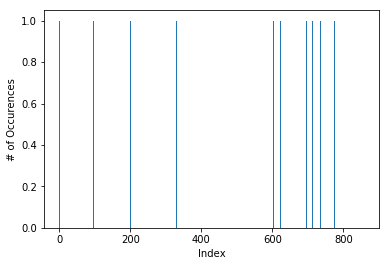

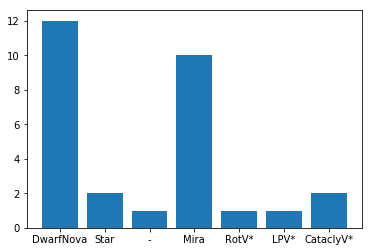

In [66]:
indexes = simbadSearch['index'].tolist()
set(indexes)
foundSum = []
objectTypes =[]
# for x in range(1,6):
tab = simbadSearch
df = tab.to_pandas()
#objectTypes.extend(df)
df2 = df[df['OTYPE'] != 'Object Not Found']
objectTypes.extend(df2['OTYPE'])
indexFound = df2['index'].tolist()
if x == 1:
    foundorNot = [1 if y in indexFound else 0 for y in indexes]
else:
    fon = [1 if y in indexFound else 0 for y in indexes]
    foundorNot = [y + z for y,z in zip(fon,foundorNot)]
index = range(len(foundorNot))
discreteOtypes = set(objectTypes)
num = []
for x in discreteOtypes:
    num.append(objectTypes.count(x))
plt.bar(index,foundorNot)
plt.xlabel('Index')
plt.ylabel('# of Occurences')
plt.show()

disoindex = range(len(num))
plt.bar(disoindex,num)
plt.xticks(disoindex, discreteOtypes)
plt.show()

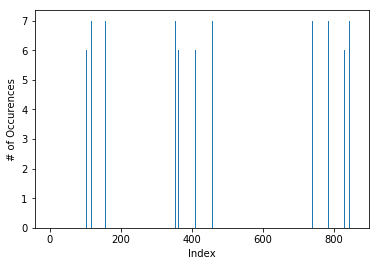

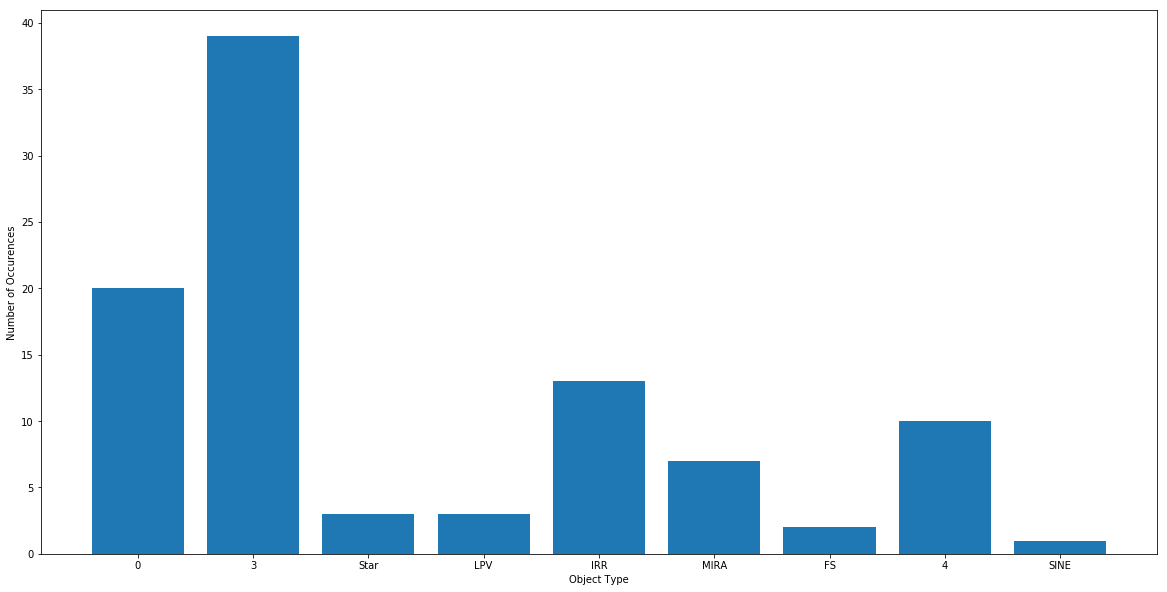

In [230]:
indexes = simbadSearch['index'].tolist()
set(indexes)
foundSum = []
objectTypes =[]

tab = vizierSearch# ascii.read('/home/mj1e16/outTablesImproved/vizier{}.csv'.format(x))
df = tab.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']
df3 = df3[df3['CLASS'] != '-']
df3 = df3[df3['CLASS'] != '']


objectTypes.extend(df3['CLASS'])
indexFound = df3['index'].tolist()
if x == 1:
    foundorNot = [1 if y in indexFound else 0 for y in indexes]
else:
    fon = [1 if y in indexFound else 0 for y in indexes]
    foundorNot = [y + z for y,z in zip(fon,foundorNot)]
        
#    df3 = df2[df2['CLASS'] != 'No Object Type']
index = range(len(foundorNot))
discreteOtypes = set(objectTypes)
num = []
for x in discreteOtypes:
    num.append(objectTypes.count(x))
    
plt.bar(index,foundorNot)
plt.xlabel('Index')
plt.ylabel('# of Occurences')
plt.show()

disoindex = range(len(num))
plt.figure(figsize=[20,10])
plt.bar(disoindex,num)
plt.xticks(disoindex, discreteOtypes)
plt.ylabel('Number of Occurences')
plt.xlabel('Object Type')
plt.savefig('/home/mj1e16/thesisFigures/vizierotypes.png')
plt.show()

In [222]:
vizierSearch

RA_d,DEC_d,Vmag,CLASS,xcentroid,ycentroid,flux,IMAGE,index
float64,float64,object,object,float64,float64,float64,object,int64
0.0,0.0,-,-,0.0,0.0,0.0,-,0
285.3085242660774,38.64320337442705,0,Object Not Found,817.5698,251.1989,3081.252,diff_imNo11_channel72_ccd12.fits,0
283.4488845006899,46.91229413625908,0,Object Not Found,977.2311,335.0007,1563.474,diff_imNo11_channel9_ccd13.fits,0
281.2626986253877,48.092472568384956,0,Object Not Found,881.0323,160.3248,1447.371,diff_imNo11_channel11_ccd15.fits,0
282.4562432093736,48.71368743412436,0,Object Not Found,433.0373,179.9004,1633.5,diff_imNo11_channel12_ccd16.fits,0
284.5588528253113,44.51322961355488,0,Object Not Found,804.2537,448.7743,2189.427,diff_imNo11_channel27_ccd19.fits,0
285.02991137598053,43.780980764606234,0,Object Not Found,91.0074,292.5105,2139.691,diff_imNo11_channel27_ccd19.fits,0
288.4724636796787,43.80081740402751,0,Object Not Found,849.4122,32.2863,14608.01,diff_imNo11_channel45_ccd21.fits,0
287.4616317565798,43.91652339662211,0,Object Not Found,386.4077,513.6817,8640.346,diff_imNo11_channel45_ccd21.fits,0


In [42]:
num = 1
simbadTab = ascii.read('/home/mj1e16/outTablesImproved/simbad{}.csv'.format(num))
df = simbadTab.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [228]:
# num = 2
# vizTab = ascii.read('/home/mj1e16/outTablesImproved/vizier{}.csv'.format(num))
df = vizierSearch
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']
df3
print(len(df3))

111


In [ ]:
df

In [47]:
a = [1,2,3,3,3,3]
B = set(a)
print(B,a)

(set([1, 2, 3]), [1, 2, 3, 3, 3, 3])


In [35]:
c

[0, 1, 1]

In [21]:
ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/simbad2.csv',format='csv',fast_writer=False)

In [232]:
ascii.write(vizierSearch,'/home/mj1e16/outTablesImproved/vizier.csv',format='csv',fast_writer=False)

In [22]:
simbad2 = ascii.read('/home/mj1e16/outTablesImproved/simbad2.csv')

In [27]:
df = simbadSearch.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
0,-,0.000000,0.000000,-,0.0000,0.0000,0.000,-,0
5,2MASS J19044019+3740211,286.167452,37.672530,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,4
6,KIC 6267115,284.719670,41.676007,Star,947.2881,593.7286,3451.970,diff_imNo25_channel49_ccd49.fits,5
7,2MASS J19393539+4900241,294.897457,49.006710,RGB*,645.0120,273.6120,3651.136,diff_imNo31_channel13_ccd13.fits,6
8,KIC 10256300,283.158837,47.393771,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
12,KOI-6167,283.066275,43.743557,EB*Algol,851.0325,318.8774,4745.730,diff_imNo40_channel30_ccd54.fits,11
24,KIC 11124157,284.165028,48.762276,Star,46.3901,778.0478,2068.993,diff_imNo7_channel7_ccd35.fits,23
27,KIC 11014223,282.702775,48.599169,RotV*,382.8395,347.2336,2633.672,diff_imNo33_channel12_ccd12.fits,26
31,V* WY Lyr,283.432181,40.304176,Mira,828.0455,122.7324,46189.730,diff_imNo13_channel51_ccd79.fits,30
32,ASAS J195004+4336.4,297.517376,43.605445,V*,731.5602,243.9939,14502.800,diff_imNo32_channel60_ccd28.fits,31


In [24]:
df = simbad2.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2


,MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
0,-,0.000000,0.000000,-,0.0000,0.0000,0.000,-,0
7,2MASS J19393539+4900241,294.897457,49.006710,RGB*,645.0120,273.6120,3651.136,diff_imNo31_channel13_ccd13.fits,6
8,KIC 10256300,283.158837,47.393771,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
12,KOI-6167,283.066275,43.743557,EB*Algol,851.0325,318.8774,4745.730,diff_imNo40_channel30_ccd54.fits,11
27,KIC 11014223,282.702775,48.599169,RotV*,382.8395,347.2336,2633.672,diff_imNo33_channel12_ccd12.fits,26
32,ASAS J195004+4336.4,297.517376,43.605445,V*,731.5602,243.9939,14502.800,diff_imNo32_channel60_ccd28.fits,31
33,KIC 11284185,284.144097,49.035986,Star,192.0007,575.1609,2626.705,diff_imNo42_channel7_ccd79.fits,32


In [234]:
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,index
object,float64,float64,object,float64,float64,float64,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0
N/A,291.9081476036849,47.058497168533194,Object Not Found,429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits,0
N/A,282.2997286819453,48.51511298543987,Object Not Found,618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits,1
N/A,286.17639521590405,44.443401074095455,Object Not Found,127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits,2
N/A,282.51787304188844,47.587614950317615,Object Not Found,1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits,3
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,4
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits,5
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits,6
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7


In [28]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=1*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']
df3

44
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DEJ2000   _V  Class
    deg         deg               
----------- ----------- ---- -----
283.1589100  47.3937700 VMAG     0
  _RAJ2000    _DE

KeyboardInterrupt: 

In [177]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=5*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
286.16748900  37.67248900     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
294.8974900  49.0067900     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
283.1589100  47.3937700     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
283.0662600  43.7436300     0 VMAG
283.0661900  43.7436600     0 VMAG
  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
281.39102500  47.86203800     3 VMAG
281.39086300  47.86210500     3 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
282.7028400  48.5993200     0 VMAG
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
--

,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
0,0.000000,0.000000,-,0,0.0000,0.0000,0.000,-
5,286.167489,37.672489,0,VMAG,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
7,294.897490,49.006790,0,VMAG,645.0120,273.6120,3651.136,diff_imNo31_channel13_ccd13.fits
8,283.158910,47.393770,0,VMAG,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits
12,283.066260,43.743630,0,VMAG,851.0325,318.8774,4745.730,diff_imNo40_channel30_ccd54.fits
22,281.391025,47.862038,3,VMAG,807.2390,369.9034,1363.519,diff_imNo48_channel11_ccd15.fits
27,282.702840,48.599320,0,VMAG,382.8395,347.2336,2633.672,diff_imNo33_channel12_ccd12.fits
31,283.432200,40.304170,0,VMAG,828.0455,122.7324,46189.730,diff_imNo13_channel51_ccd79.fits
32,297.517357,43.605428,0,VMAG,731.5602,243.9939,14502.800,diff_imNo32_channel60_ccd28.fits
33,284.144030,49.035960,0,VMAG,192.0007,575.1609,2626.705,diff_imNo42_channel7_ccd79.fits


In [178]:
vizierSearch

RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
float64,float64,object,object,float64,float64,float64,object
0.0,0.0,-,0,0.0,0.0,0.0,-
291.9081476036849,47.058497168533194,Object Not Found,[0],429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits
282.2997286819453,48.51511298543987,Object Not Found,[0],618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits
286.17639521590405,44.443401074095455,Object Not Found,[0],127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits
282.51787304188844,47.587614950317615,Object Not Found,[0],1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits
286.167489,37.672489,0,VMAG,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
284.7198297858132,41.675149597439834,Object Not Found,[0],947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits
294.89749,49.00679,0,VMAG,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits
283.15891,47.39377,0,VMAG,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits


In [7]:
tabTot =  ascii.read('/home/mj1e16/outTablesImproved/sexdiffOutTest.csv')

In [322]:
tabTot = ascii.read('/home/mj1e16/outTablesImproved/firsthalf.csv')

In [61]:
# upload_resource = '/home/mj1e16/outTables15/matchplus3Magdiff.csv'
# j = Gaia.launch_job(query="select * from tap_upload.table_test", upload_resource=upload_resource, \
# upload_table_name="table_test", verbose=True)
# r = j.get_results()
# r.pprint()

In [231]:
def gaiaSearch(table):
    RA = table['RA']
    DEC = table['DEC']
    width = u.Quantity(2.5, u.arcsecond)
    height = u.Quantity(2.5, u.arcsecond)
    #coord = [str(RA[0])+','+str(DEC[0])]
    t0 = time.time()
    for x in range(len(RA)):
        coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
        if x ==0:
            result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
        else:
            newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
            if len(newtab) != 0:
                result_table.add_row(newtab[0])
    print(time.time() - t0)
    return result_table

In [42]:
def colourMag(table,maxError=0.5):
    parallax = table['parallax']
    distance = [1./(x/1000.) for x in parallax]
    paraError = table['parallax_error']
    colour = table['bp_rp']
    gmag = table['phot_g_mean_mag']
    extinction = table['a_g_val']


    colourGood = [x for x,y,z in zip(colour,paraError,parallax) if y<maxError*z]
    distanceGood = [x for x,y,z in zip(distance,paraError,parallax) if y<maxError*z]
    gmagGood = [x for x,y,z in zip(gmag,paraError,parallax) if y<maxError*z]
    exctinctionGood = [x for x,y,z in zip(extinction,paraError,parallax) if y<maxError*z]

    absoluteMag = [mag - (5*(np.log10(dist)))  + 5 for mag,dist,ext in zip(gmagGood,distanceGood,exctinctionGood)]
    return {'absMag':absoluteMag,'colour':colourGood}

In [113]:
# RA = tabTot['RA']
# DEC = tabTot['DEC']
# width = u.Quantity(5., u.arcsecond)
# height = u.Quantity(5., u.arcsecond)
# #coord = [str(RA[0])+','+str(DEC[0])]
# t0 = time.time()
# for x in range(10000): #len(RA)):
#     coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
#     if x ==0:
#         result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#     else:
#         newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#         if len(newtab) != 0:
#             result_table.add_row(newtab[0])
# print(time.time() - t0)

In [12]:
#ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaObjects.csv',format='csv',fast_writer=False)
ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaTab.csv',format='csv',fast_writer=False)

In [13]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [115]:
simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=5*u.arcsecond)

In [180]:
oclass = vizierSearch['CLASS']
vmag = vizierSearch['Vmag']
simbadSearch['Vmag'] = vmag
simbadSearch['Class'] = oclass
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,Vmag,Class
object,float64,float64,object,float64,float64,float64,object,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0,-
N/A,291.9081476036849,47.058497168533194,Object Not Found,429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits,[0],Object Not Found
N/A,282.2997286819453,48.51511298543987,Object Not Found,618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits,[0],Object Not Found
N/A,286.17639521590405,44.443401074095455,Object Not Found,127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits,[0],Object Not Found
N/A,282.51787304188844,47.587614950317615,Object Not Found,1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits,[0],Object Not Found
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,VMAG,0
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits,[0],Object Not Found
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits,VMAG,0
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,VMAG,0


In [182]:
ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/otypes.csv',format='csv',fast_writer=False)

In [154]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=5*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

Empty TableList
Empty TableList
Empty TableList
Empty TableList
TableList with 2 tables:
	'0:I/271/out' with 4 column(s) and 1 row(s) 
	'1:I/305/out' with 4 column(s) and 1 row(s) 
  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
286.16748900  37.67248900     0 VMAG
Empty TableList
TableList with 4 tables:
	'0:I/254/out' with 4 column(s) and 1 row(s) 
	'1:I/255/out' with 4 column(s) and 1 row(s) 
	'2:I/271/out' with 4 column(s) and 1 row(s) 
	'3:I/305/out' with 4 column(s) and 1 row(s) 
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
294.8974900  49.0067900     0 VMAG
TableList with 4 tables:
	'0:I/254/out' with 4 column(s) and 1 row(s) 
	'1:I/255/out' with 4 column(s) and 1 row(s) 
	'2:I/271/out' with 4 column(s) and 2 row(s) 
	'3:I/305/out' with 4 column(s) and 2 row(s) 
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ---

In [157]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
0,-,0.0,0.0,-,0.0,0.0,0.0,0.0,-


In [128]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
smallTab = Table.from_pandas(df2)
smallTab

MAIN_ID,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
str1,float64,float64,str1,float64,float64,float64,float64,str1
-,0.0,0.0,-,0.0,0.0,0.0,0.0,-


In [117]:
df = simbadSearch.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
smallTab = Table.from_pandas(df2)
smallTab

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE
str23,float64,float64,str8,float64,float64,float64,str32
-,0.0,0.0,-,0.0,0.0,0.0,-
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits
KOI-6167,283.0662745616069,43.7435568227975,EB*Algol,851.0325,318.8774,4745.73,diff_imNo40_channel30_ccd54.fits


In [17]:
tabTot = ascii.read('/home/mj1e16/outTablesImproved/final/10sn.csv')

In [19]:
result_table = gaiaSearch(tabTot[0:10000])

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

In [23]:
print(len(result_table))

6599


In [232]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/final/magone.csv')

In [25]:
newGaiaTab = gaiaSearch(otherGaiaTab)

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

In [233]:
newnewGaiaTab = gaiaSearch(otherGaiaTab)

AttributeError: 'Job' object has no attribute 'set_failed'

In [ ]:

newnewGaiaTab = gaiaSearch(otherGaiaTab)

In [435]:
df = otherGaiaTab.to_pandas()
df = df[df['magDiff'] < -3]
maglessthan3 = Table.from_pandas(df)

In [437]:
gaiasearch3 = gaiaSearch(maglessthan3)

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.


KeyboardInterrupt: 

In [472]:
snratio = findSNratio(maglessthan3)
maglessthan3['S/N'] = snratio

In [475]:
maglessthan3.remove_columns(['index','NUMBER'])

In [478]:
index = range(len(maglessthan3))
maglessthan3['INDEX'] = index

In [479]:
new_order = ['INDEX','RA','DEC','IMAGE_NAME','Number_of_Observations','FLUX_BEST','FLUXERR_BEST','MAG_BEST','MAGERR_BEST','X_IMAGE','Y_IMAGE','ELLIPTICITY','magDiff','MAG_BEST_ORIG','S/N']

In [480]:
maglessthan3New = maglessthan3[new_order]

In [483]:
ascii.write(maglessthan3New,'/home/mj1e16/outTablesImproved/final/3magobjects.csv',format='csv',fast_writer=False)

In [26]:
# if using a table previously made
#result_table = ascii.read('/home/mj1e16/outTablesImproved/gaiaTab.csv')

In [482]:
maglessthan3New

INDEX,RA,DEC,IMAGE_NAME,Number_of_Observations,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,magDiff,MAG_BEST_ORIG,S/N
int64,float64,float64,str34,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,283.4488845006899,46.91229413625908,kplr2009114174833_ffi-cal.fits[13],1,1563.474,5.890203,17.0148,0.0041,977.2311,335.0007,0.155,-4.065613299233601,16.9888,3.7218091547836627
1,285.1104288196375,50.03423213078796,kplr2009114174833_ffi-cal.fits[36],1,2366.871,9.394968,16.5646,0.0043,1036.9814,203.4899,0.476,-4.07339239721763,16.5388,4.579721421959671
2,288.391282918965,46.04365796743568,kplr2009114174833_ffi-cal.fits[38],1,5791.752,9.427667,15.593,0.0018,683.0656,458.6525,0.705,-3.3397798671119427,15.5417,7.074229180906268
3,283.14298172112916,43.81784710740569,kplr2009114204835_ffi-cal.fits[2],1,1997.534,7.224836,16.7488,0.0039,872.8683,244.0262,0.269,-3.8458548353691926,16.7169,4.194572020432017
4,291.3337378325702,47.223530236732735,kplr2009114204835_ffi-cal.fits[58],1,3272.575,17.0201,16.2128,0.0056,211.0047,340.0446,0.563,-3.4284402555214575,16.1656,5.328427065714181
5,284.83763764917904,42.51435969715562,kplr2009114204835_ffi-cal.fits[5],1,1907.738,5.838006,16.7987,0.0033,392.0074,72.9786,0.37,-3.018542939272951,16.7292,4.023738580673868
6,297.64882110604634,48.70359757403083,kplr2009115053616_ffi-cal.fits[79],1,5967.598,13.10438,15.5605,0.0024,41.88,591.88,0.584,-3.1301353682848,15.498,7.141197680150504
7,281.466638635803,42.863017933586406,kplr2009115080620_ffi-cal.fits[3],1,1981.667,7.83841,16.7574,0.0043,890.5517,521.852,0.021,-3.4727578278128437,16.7122,4.15048600025544
8,283.8461902159935,47.95027929173198,kplr2009115131122_ffi-cal.fits[13],1,1581.959,6.423609,17.002,0.0044,206.8945,925.1936,0.499,-4.598922748746443,16.9862,3.7627042712893135


In [27]:
refmagandcolour = colourMag(result_table)

In [45]:
magandcolour = colourMag(newGaiaTab,maxError=.9)

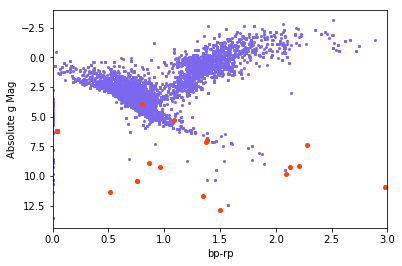

In [215]:
plt.plot(refmagandcolour['colour'],refmagandcolour['absMag'],'o',color='mediumslateblue',markersize=2)
plt.plot(magandcolour['colour'],magandcolour['absMag'],'o',color='orangered',markersize=4)
# plt.ylim([-5,15])
plt.xlim([0,3])
plt.gca().invert_yaxis()
plt.ylabel('Absolute g Mag')
plt.xlabel('bp-rp')
plt.savefig('/home/mj1e16/thesisFigures/HRdiagram.png')
plt.show()

In [210]:
newGaiaTab

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
0.000502719491980354,1635721458409799680,Gaia DR2 2100858719988540672,2100858719988540672,411367046,2015.5,287.22478795158287,0.12924609172102045,41.369646875243895,0.17035854684675494,0.2347910984896226,0.15868251157157018,1.4796281,-4.047697448627969,0.30285849869732423,-5.639221732351132,0.3982678976131423,-0.10248186,-0.021221615,-0.16414519,0.07204145,-0.0134161115,0.08093007,-0.40664792,-0.096351504,-0.041249715,-0.13182849,202,0,202,0,1.5540609,228.74802,0.47005878611639984,1.2099163882750155,31,False,0.5097705,1.5308295342089953,0.04093561721468709,0.029385779,23,16,0.36550173,0,25,False,216,816.8316547325105,1.5034227838432015,543.3147,18.408035,21,396.2719503810035,12.268033152538791,32.30118,18.856405,23,627.996442743967,9.680230914542538,64.874115,17.767027,1.2539529,0,1.0893784,0.44836998,0.6410084,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.31384909385085,14.508800286103599,299.37721800633994,63.06297924554458,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2100858719988540672,--
7.667296081266225e-05,1635721458409799680,Gaia DR2 2104030982831264128,2104030982831264128,861939134,2015.5,284.6467222204235,0.19786997545371848,41.18803348163022,0.27849909585753546,0.28588

In [218]:
len(df)

58

In [217]:
df = newGaiaTab.to_pandas()
uni = df['designation'].unique()
print(uni)
print(len(uni))

['Gaia DR2 2100858719988540672' 'Gaia DR2 2104030982831264128'
 'Gaia DR2 2119129442143508736' 'Gaia DR2 2125911332946378880'
 'Gaia DR2 2139235661527812352' 'Gaia DR2 2119218335083289600'
 'Gaia DR2 2132673024515321088' 'Gaia DR2 2131713627601629056'
 'Gaia DR2 2052372185650324608' 'Gaia DR2 2132939514346964480'
 'Gaia DR2 2131648829432513536' 'Gaia DR2 2119131301867271808'
 'Gaia DR2 2136194073063876608' 'Gaia DR2 2051012566501844608'
 'Gaia DR2 2105423926625484672' 'Gaia DR2 2103778541833098880'
 'Gaia DR2 2106680913230249216' 'Gaia DR2 2104406362973602816'
 'Gaia DR2 2127905125481040768' 'Gaia DR2 2073821488542867584'
 'Gaia DR2 2128309921856039424' 'Gaia DR2 2119690334809480576'
 'Gaia DR2 2051843767233035776' 'Gaia DR2 2107190949188337408'
 'Gaia DR2 2107312853241744128' 'Gaia DR2 2119644769499083648'
 'Gaia DR2 2106031887836453248' 'Gaia DR2 2129846381980885504'
 'Gaia DR2 2106814263376434176' 'Gaia DR2 2107272171310917632'
 'Gaia DR2 2133656499007093888' 'Gaia DR2 2101296394333

In [27]:
gaiaMag = result_table['phot_g_mean_mag']
keplerMag = tabTot['MAG_BEST'][0:10000]

In [35]:
df = newGaiaTab.to_pandas()
uni = df['designation'].unique()

In [36]:
uni

array(['Gaia DR2 2100858719988540672', 'Gaia DR2 2104030982831264128',
       'Gaia DR2 2119129442143508736', 'Gaia DR2 2125911332946378880',
       'Gaia DR2 2139235661527812352', 'Gaia DR2 2119218335083289600',
       'Gaia DR2 2132673024515321088', 'Gaia DR2 2131713627601629056',
       'Gaia DR2 2052372185650324608', 'Gaia DR2 2132939514346964480',
       'Gaia DR2 2131648829432513536', 'Gaia DR2 2119131301867271808',
       'Gaia DR2 2136194073063876608', 'Gaia DR2 2051012566501844608',
       'Gaia DR2 2105423926625484672', 'Gaia DR2 2103778541833098880',
       'Gaia DR2 2106680913230249216', 'Gaia DR2 2104406362973602816',
       'Gaia DR2 2127905125481040768', 'Gaia DR2 2073821488542867584',
       'Gaia DR2 2128309921856039424', 'Gaia DR2 2119690334809480576',
       'Gaia DR2 2051843767233035776', 'Gaia DR2 2107190949188337408',
       'Gaia DR2 2107312853241744128', 'Gaia DR2 2119644769499083648',
       'Gaia DR2 2106031887836453248', 'Gaia DR2 2129846381980885504',
      

In [37]:
def testfindMatches(tabTot,matchTab,arcsec=2.5*u.arcsec,low=0,high=10000):
    tabMini = tabTot[low:high]
    matches = 'not matched'
    ra1 = matchTab['ra']
    dec1 = matchTab['dec']
    idx = []
    ra2 = tabMini['RA']
    dec2 = tabMini['DEC']    
    c = SkyCoord(ra=ra1, dec=dec1,unit=(u.hourangle,u.deg),frame='fk5')
    catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog)
    sep_constraint = d2d < max_sep
#     print(len(matches))
#     print(matches)
    tabMini.remove_rows(idx)
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['NUMBER'].isin(objectsFound)]
    return tabMini

In [308]:
def findSExGaia(tab,match,max_sep = 1. * u.arcsec):
    
    df = tab.to_pandas()
    bigdf = match.to_pandas()
    
    number1 = match['index']
    ra1 = match['ra'].tolist()
    dec1 = match['dec'].tolist()

    number2 = tab['index'] # difference image
    ra2 = tab['RA'].tolist()
    dec2 = tab['DEC'].tolist()    
#     print(ra1,ra2)
#     print(dec1,dec2)
    cat1 = SkyCoord(ra=ra1*u.deg, dec=dec1*u.deg)
    cat2 = SkyCoord(ra=ra2*u.deg, dec=dec2*u.deg)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matches = idx[sep_constraint]
    
#     print(objectsFound)
#     print(matches)
    matchdf = df[df['index'].isin(objectsFound)]
    matchTab = Table.from_pandas(matchdf)
#     print(matches)
    testnum = [bigdf['index'][x] for x in matches]
    parallax = [bigdf['parallax'][x] for x in matches]
    parallaxError = [bigdf['parallax_error'][x] for x in matches]
    phot_g_mean_flux = [bigdf['phot_g_mean_flux'][x] for x in matches]
    bp_rp = [bigdf['bp_rp'][x] for x in matches]
#     print(testnum)
#     print(objectsFound)
#     testra = [bigdf['ra'][x] for x in matches]
#     testdec = [bigdf['dec'][x] for x in matches]
#     idx, d2d, d3d = cat1.match_to_catalog_sky(cat2)
#     sep_constraint = d2d < max_sep
#     #istrue = [x for x in sep_constraint if x == True]
#     objectsFound = number1[sep_constraint]
#     origdf = bigdf[bigdf['index'].isin(objectsFound)]
#     origTab = Table.from_pandas(origdf)
    matchTab['parallax'] = parallax
    matchTab['parallaxError'] = parallaxError
    matchTab['phot_g_mean_flux'] = phot_g_mean_flux
    matchTab['bp_rp'] = bp_rp
    #matchTab[''] = 
    
    return matchTab

In [312]:
def findSExSimbad(tab,match,max_sep = 1. * u.arcsec):
    
    df = tab.to_pandas()
    bigdf = match.to_pandas()
    
    number1 = match['index']
    ra1 = match['RA_d'].tolist()
    dec1 = match['DEC_d'].tolist()

    number2 = tab['index'] # difference image
    ra2 = tab['RA'].tolist()
    dec2 = tab['DEC'].tolist()    
#     print(ra1,ra2)
#     print(dec1,dec2)
    cat1 = SkyCoord(ra=ra1*u.deg, dec=dec1*u.deg)
    cat2 = SkyCoord(ra=ra2*u.deg, dec=dec2*u.deg)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matches = idx[sep_constraint]
    
#     print(objectsFound)
#     print(matches)
    matchdf = df[df['index'].isin(objectsFound)]
    matchTab = Table.from_pandas(matchdf)
#     print(matches)
    testnum = [bigdf['index'][x] for x in matches]
    MAIN_ID = [bigdf['MAIN_ID'][x] for x in matches]
    OTYPE = [bigdf['OTYPE'][x] for x in matches]
#     phot_g_mean_flux = [bigdf['phot_g_mean_flux'][x] for x in matches]
#     bp_rp = [bigdf['bp_rp'][x] for x in matches]
#     print(testnum)
#     print(objectsFound)
#     testra = [bigdf['ra'][x] for x in matches]
#     testdec = [bigdf['dec'][x] for x in matches]
#     idx, d2d, d3d = cat1.match_to_catalog_sky(cat2)
#     sep_constraint = d2d < max_sep
#     #istrue = [x for x in sep_constraint if x == True]
#     objectsFound = number1[sep_constraint]
#     origdf = bigdf[bigdf['index'].isin(objectsFound)]
#     origTab = Table.from_pandas(origdf)
    matchTab['MAIN_ID'] = MAIN_ID
    matchTab['OTYPE'] = OTYPE
#     matchTab['phot_g_mean_flux'] = phot_g_mean_flux
#     matchTab['bp_rp'] = bp_rp
    #matchTab[''] = 
    
    return matchTab

In [466]:
def findSNratio(table,gain=110):
    signal = [x for x in table['FLUX_BEST']]
    originalImageFlux = [x*100**((y-z)/5) for x,y,z in zip(table['FLUX_BEST'],table['MAG_BEST'],table['MAG_BEST_ORIG'])]
    medianFlux = [x-y for x,y in zip(originalImageFlux,signal)]
    noise = [((x/gain)+(y/(gain*(13))))**0.5 for x,y in zip(originalImageFlux,medianFlux)]
    snratio = [(x/gain)/y for x,y in zip(signal,noise)]
    return snratio

In [467]:
newtab = ascii.read('/home/mj1e16/outTablesImproved/final/magone.csv')
snratio = findSNratio(newtab)

In [468]:
snratio

[4.848164745409354,
 3.7218091547836627,
 3.3404413883461794,
 3.50705638486412,
 3.652172984716581,
 3.4219724924634134,
 10.639408124384397,
 7.448803045148305,
 3.96853747997856,
 4.579721421959671,
 4.035823668113194,
 7.074229180906268,
 5.844966703463903,
 4.163374259366598,
 5.6037121051055045,
 6.619921611853549,
 3.060459497036734,
 4.37429678299634,
 3.164237000064376,
 4.33885210556834,
 3.4194412637959615,
 4.006451728898163,
 4.332783822807662,
 6.852372754839711,
 4.465537013346168,
 3.4428318527438218,
 3.8866748838457843,
 4.743495817227196,
 4.194572020432017,
 3.25685815791758,
 3.7355879310027493,
 5.2593468623655255,
 2.934476080854144,
 2.7008159768068083,
 5.040457869206562,
 4.795650309377973,
 5.081981717805397,
 7.065075498162932,
 3.944357302296816,
 5.328427065714181,
 4.023738580673868,
 6.187399836775475,
 3.4833438500969467,
 4.955750177078245,
 4.923000875798064,
 3.1711184751678334,
 3.832301512975764,
 3.0596831525492667,
 4.619582765965209,
 3.09017772

In [439]:
datesfull = [[54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.21309222], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [54946.31730352], [54946.31730352], [54946.31730352], [54946.31730352], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.52913182], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54946.71303422], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [54947.14581722], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55153.95927784, 56303.65251524, 55832.78062804, 55864.77969804, 55895.73660944, 55090.98512704, 56267.89370604, 55492.78603754, 56236.81420744, 55182.01619934, 55769.45696544, 55062.80492724, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 55552.06392474, 55522.74170174, 56168.81112794], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55062.80492724], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [55090.98512704], [56267.89370604, 55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55123.06602474], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55153.95927784], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55182.01619934], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55215.93445914], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55216.01483134], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55245.74556834], [55274.71942834], [55274.71942834], [55274.71942834], [55274.71942834], [55274.71942834], [55274.71942834], [55274.71942834], [55274.71942834], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [55274.71942834], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55307.51459974], [55307.51459974], [55307.51459974], [55307.51459974], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [55336.40771054], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55336.40771054], [55336.40771054], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55370.67486344], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55399.03668604], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55430.79050564], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55461.80869384], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55492.78603754], [55522.74170174], [55522.74170174], [55522.74170174], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55522.74170174], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55552.06392474], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55585.55556804], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55614.71846884], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [55677.42404264], [56047.49693394, 55153.95927784, 55307.51459974, 56303.65251524, 55832.78062804, 56014.53748484, 55461.80869384, 55864.77969804, 55895.73660944, 55090.98512704, 56267.89370604, 55492.78603754, 56330.54311544, 55677.42404264, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 55123.06602474, 55930.84151904, 55552.06392474, 55522.74170174, 56357.47460744, 55958.40644554, 55245.74556834, 55986.50257794], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [55706.62358874], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55706.62358874], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074], [55738.43871074, 55895.73660944, 56137.50692204], [55738.43871074], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55769.45696544], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55801.74198404], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55801.74198404, 55153.95927784, 55307.51459974, 56303.65251524, 55832.78062804, 56014.53748484, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 55216.01483134, 56105.56916384, 55182.01619934, 55274.71942834, 56137.50692204, 55614.71846884, 55585.55556804, 54945.99778262, 54947.14581722, 55123.06602474, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55832.78062804], [55864.77969804], [55864.77969804], [55864.77969804], [55864.77969804], [55864.77969804], [55864.77969804], [55864.77969804], [55864.77969804], [55864.77969804], [55738.43871074, 55895.73660944, 56137.50692204], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55895.73660944], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55930.84151904], [55958.40644554], [55958.40644554], [55958.40644554], [55958.40644554], [55958.40644554], [55958.40644554], [55958.40644554], [55958.40644554], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [55986.50257794], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56014.53748484], [56047.49693394], [56047.49693394], [56047.49693394], [56047.49693394], [56047.49693394, 55245.74556834], [56047.49693394], [56047.49693394], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [56047.49693394], [56047.49693394], [56047.49693394], [56047.49693394], [56047.49693394], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56077.43209024], [56303.65251524, 55864.77969804, 56390.47480454, 55062.80492724, 56137.50692204, 56077.43209024, 55399.03668604, 55958.40644554], [56077.43209024], [56077.43209024], [56077.43209024], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [56077.43209024], [56105.56916384], [56105.56916384], [56105.56916384], [56105.56916384], [56105.56916384], [56105.56916384], [56105.56916384], [56047.49693394, 55801.74198404, 55153.95927784, 55307.51459974, 55738.43871074, 56303.65251524, 55832.78062804, 55370.67486344, 56014.53748484, 55461.80869384, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 56390.47480454, 55216.01483134, 55430.79050564, 56105.56916384, 55182.01619934, 55769.45696544, 55062.80492724, 55274.71942834, 56137.50692204, 55614.71846884, 55706.62358874, 55585.55556804, 56077.43209024, 54945.99778262, 54947.14581722, 55123.06602474, 55399.03668604, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 56357.47460744, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [56105.56916384], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [55738.43871074, 55895.73660944, 56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56137.50692204], [56168.81112794], [55801.74198404, 55153.95927784, 55307.51459974, 56303.65251524, 55832.78062804, 56014.53748484, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 55216.01483134, 56105.56916384, 55182.01619934, 55274.71942834, 56137.50692204, 55614.71846884, 55585.55556804, 54945.99778262, 54947.14581722, 55123.06602474, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [56168.81112794], [56168.81112794], [56168.81112794], [56168.81112794], [56168.81112794], [56168.81112794], [56168.81112794], [56168.81112794], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [55801.74198404, 55153.95927784, 55307.51459974, 56303.65251524, 55832.78062804, 56014.53748484, 54945.72162632, 55864.77969804, 55895.73660944, 55090.98512704, 54945.84664962, 56267.89370604, 54946.31730352, 55492.78603754, 56330.54311544, 55677.42404264, 55336.40771054, 55215.93445914, 56236.81420744, 55216.01483134, 56105.56916384, 55182.01619934, 55274.71942834, 56137.50692204, 55614.71846884, 55585.55556804, 54945.99778262, 54947.14581722, 55123.06602474, 55930.84151904, 56203.83432484, 54946.71303422, 55552.06392474, 55522.74170174, 56168.81112794, 54946.21309222, 54946.52913182, 55958.40644554, 55245.74556834, 55986.50257794], [56203.83432484], [56203.83432484], [56203.83432484], [56203.83432484], [56203.83432484], [56203.83432484], [56203.83432484], [56236.81420744], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56236.81420744], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604, 55123.06602474], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56267.89370604], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56303.65251524], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56330.54311544], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [56357.47460744], [55801.74198404, 55370.67486344, 54945.72162632, 55895.73660944, 54945.84664962, 54946.31730352, 56236.81420744, 56105.56916384, 55182.01619934, 55274.71942834, 54945.99778262, 54947.14581722, 56203.83432484, 54946.71303422, 55522.74170174, 56357.47460744, 54946.21309222, 54946.52913182], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454], [56390.47480454]]
magnitudefull = [[16.1003], [16.9888], [16.9315], [16.776], [16.2405], [16.1544], [14.4266], [14.8043], [16.7348], [16.5388], [16.3768], [15.5417], [15.3236], [16.3195], [15.6635], [15.0062], [16.4726], [15.7855], [16.484], [16.3442], [16.4713], [16.727], [16.1744], [15.4442], [16.1066], [16.1615], [16.3659], [16.1089], [16.7169], [16.8988], [16.8516], [16.0444], [16.5279], [16.8775], [16.0662], [15.5721], [16.206], [15.002], [16.3745], [16.1656], [16.7292], [15.3394], [16.6347], [15.851], [15.8506], [16.8753], [16.4037], [16.5439], [15.7462], [16.7723], [16.3143], [15.8123], [16.6514], [15.9275], [16.0119], [15.3219], [15.7012], [16.3662], [15.7668], [16.2449], [15.2556], [15.3419], [14.6697], [15.6641], [16.8199], [16.8899], [15.0204], [15.6184], [17.1596], [16.1568], [15.6479], [16.6355], [16.117], [15.9253], [16.2124], [16.5516], [16.2446], [15.6277], [15.5495], [16.004], [16.208], [16.0622], [15.498], [15.4826], [16.7398], [15.4922], [16.6922], [15.709], [16.5264], [16.651], [16.4931], [15.7938], [16.6183], [16.1956], [16.7122], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [16.2084], [15.6344], [15.96], [16.2236], [16.9862], [16.8898], [16.7946], [16.8729], [16.6508], [16.2535], [15.9918], [16.3614], [15.7594], [15.5797], [16.7871], [16.5457], [15.38], [15.69], [15.5901], [16.6752], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [16.232], [16.4717], [15.7476], [16.195], [15.2118], [16.6832], [16.0278], [16.764], [16.1525], [16.5014], [14.9801], [16.5916], [15.7509], [16.2427], [15.9423], [16.0995], [15.8608], [15.2276], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [15.825], [16.4623], [16.0547], [15.9675], [15.5816], [15.7304], [16.4147], [16.732], [16.0452], [16.6154], [16.686], [16.7126], [16.2285], [16.0254], [16.9817], [15.6616], [16.6894], [16.4521], [16.6982], [15.2686], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [14.6384], [15.5969], [15.4445], [15.8951], [16.5258], [15.5868], [16.1973], [14.336], [16.6049], [15.8144], [16.3501], [15.7886], [15.4563], [15.1804], [16.3189], [16.6324], [15.0341, 15.1714, 15.1714, 14.9462, 15.0561, 14.6924, 15.0543, 14.9644, 14.959, 15.1069, 15.1069, 14.6739, 14.907, 14.907, 15.1819, 15.1819, 15.1326, 15.0371, 15.0371], [15.0039], [16.3698], [16.7045], [16.4789], [16.0153], [16.1108], [16.7324], [16.5552], [15.6973], [15.9259], [16.1741], [16.2759], [16.0564, 16.1179, 16.0984, 16.0646, 16.0488, 16.138, 16.1057, 16.0305, 16.0331, 16.1216, 16.0603, 16.0889, 16.0914, 14.6233, 16.0761, 16.1133, 16.0742, 16.0686, 16.1082, 16.0523, 16.08, 16.0337, 16.1353, 16.0756, 16.0035, 16.1021, 16.065, 16.0758, 16.0852, 16.0962, 16.0223, 16.1051, 16.0134, 16.0696, 16.0462, 16.0502, 16.0654, 16.0536, 16.0107, 16.1053, 16.0847, 16.1212, 16.0648, 16.0866, 16.0947, 16.1198, 16.1031, 16.0511, 16.0542, 16.0789, 15.9769, 16.0404], [15.3361], [15.9456], [16.5411], [16.3441], [16.2448], [15.3569], [16.3467], [16.12], [16.3521], [16.7217], [16.4965], [16.6537], [15.3382, 14.2573], [15.3385], [16.7421], [14.6846], [16.3586], [15.9725], [15.3166], [16.3645], [16.3945], [16.4864], [16.691], [16.0292], [14.5288], [15.9146], [15.9973], [16.0056], [15.5424], [15.4661], [16.1045], [15.4327], [15.7645], [16.844], [15.5153], [15.7294], [16.2167], [15.6387], [15.277], [15.9795], [15.0794], [16.7508], [14.4958], [16.21], [15.8907], [15.183], [16.4313], [16.6357], [15.7088], [16.5136], [15.7407], [15.0615], [16.1748], [16.1877], [12.5652, 14.325, 14.6612, 13.1532, 13.4814, 14.4718, 14.6762, 13.9207, 12.2926, 14.5628, 13.912, 14.8724, 14.7513, 15.1982, 13.9121, 14.748, 13.9253, 14.5872, 13.356, 12.5711, 13.5064, 12.5525, 14.7891, 11.7618, 12.5511, 14.4434, 13.4942, 13.1051, 13.855, 15.1297, 12.8169, 13.8804, 12.0457, 12.9629, 12.0022, 13.0236, 13.9188, 13.9324, 15.1772, 14.1532, 14.0847, 14.6013, 13.9252, 13.5207, 14.3427, 14.2429, 11.7602, 13.9188, 13.925, 12.6905, 12.6507, 12.2044], [16.8382], [15.5351], [15.3208], [16.681], [16.0125], [15.5741], [16.4472], [16.8213], [16.1737], [15.731], [16.6984], [16.2745], [15.2915], [15.3955], [15.8516], [16.261], [16.7425], [16.1781], [14.8295], [16.7218], [16.2463], [16.785], [16.7493], [15.7356], [16.4722], [15.6893], [16.1151], [15.6432], [15.5899], [16.2985], [16.1404], [16.0215], [16.0267], [14.0086], [14.585], [16.3578], [16.0444], [16.3616], [17.09], [16.0852], [15.9775], [16.1448], [15.5176], [16.1216], [15.8365], [16.2483], [15.8319], [15.7768], [17.0939], [15.6479], [16.3288], [15.8071], [16.0636], [16.0659], [16.3116], [17.0142], [15.1865], [14.3766], [16.3385], [15.3235], [15.7787], [16.4006], [15.8787], [15.7637], [16.4803], [16.0712], [16.2181], [16.2493], [16.3098], [15.492], [16.5783], [16.1762], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [16.2738], [16.6898], [16.1744], [16.4362], [16.5239], [16.4893], [15.2097], [16.3674], [15.9262], [15.7702], [16.4705], [16.6644], [16.3566], [16.6999], [12.6565, 12.6869, 13.3227, 12.8355, 13.6931, 12.5625, 12.7285, 12.5815, 13.0861, 14.7823, 14.3285, 13.1276, 13.7766, 13.1435, 14.3503, 12.8753, 14.3485, 14.2002, 13.0448, 14.1587, 12.343, 14.7351, 13.2327, 14.5092, 14.7299, 14.1642, 13.2276, 14.13, 12.9783, 13.6933, 13.3206, 14.0893, 12.942, 14.3995, 12.7379, 12.7551, 14.3648, 14.3666, 12.8247, 13.3017, 14.3265, 14.0473, 14.3816, 13.0882, 13.3031, 14.5484, 13.8783, 14.3614, 14.3477, 14.1104, 14.3732, 13.4945], [15.3838], [16.5181], [14.2201], [16.0318], [15.1816], [16.8706], [16.8172], [16.0144], [16.083], [16.6262], [15.2476], [16.8211], [14.1887], [15.8507], [15.7653], [16.5585], [15.2575], [16.5124], [15.2926], [15.8939], [16.2476], [15.9287], [16.0263], [12.6565, 12.6869, 13.3227, 12.8355, 13.6931, 12.5625, 12.7285, 12.5815, 13.0861, 14.7823, 14.3285, 13.1276, 13.7766, 13.1435, 14.3503, 12.8753, 14.3485, 14.2002, 13.0448, 14.1587, 12.343, 14.7351, 13.2327, 14.5092, 14.7299, 14.1642, 13.2276, 14.13, 12.9783, 13.6933, 13.3206, 14.0893, 12.942, 14.3995, 12.7379, 12.7551, 14.3648, 14.3666, 12.8247, 13.3017, 14.3265, 14.0473, 14.3816, 13.0882, 13.3031, 14.5484, 13.8783, 14.3614, 14.3477, 14.1104, 14.3732, 13.4945], [16.6152], [15.7898], [15.0994], [16.234], [17.0765], [17.0381], [16.6266], [17.1544], [15.8231], [15.5922], [15.4106], [16.2427], [16.551], [13.9599], [16.6051], [12.6565, 12.6869, 13.3227, 12.8355, 13.6931, 12.5625, 12.7285, 12.5815, 13.0861, 14.7823, 14.3285, 13.1276, 13.7766, 13.1435, 14.3503, 12.8753, 14.3485, 14.2002, 13.0448, 14.1587, 12.343, 14.7351, 13.2327, 14.5092, 14.7299, 14.1642, 13.2276, 14.13, 12.9783, 13.6933, 13.3206, 14.0893, 12.942, 14.3995, 12.7379, 12.7551, 14.3648, 14.3666, 12.8247, 13.3017, 14.3265, 14.0473, 14.3816, 13.0882, 13.3031, 14.5484, 13.8783, 14.3614, 14.3477, 14.1104, 14.3732, 13.4945], [15.8105], [16.0273], [16.3765], [15.467], [16.0577], [16.0445], [15.9161], [15.1217], [16.0452], [16.5023], [16.0647], [16.0232], [16.3556], [16.1197], [16.8014], [15.3936], [15.5444], [16.4411], [16.3446], [16.5036], [16.5162], [16.1005], [16.0998], [15.5171], [15.6689], [16.5657], [16.1805], [16.2278], [15.2788], [16.3197], [16.0973], [15.7203], [16.5111], [16.0621], [15.4909], [15.9074], [15.7261], [16.0428], [16.9357], [16.4427], [16.4041], [16.5693], [15.5881], [16.2191], [16.5401], [16.9324], [16.3562], [14.8347], [15.4619], [15.4592], [16.5284], [16.137], [15.7407], [16.4672], [15.4932], [16.1556], [16.452], [16.5489], [16.3161], [15.8252], [16.7153], [16.4513], [16.7031], [15.5806], [16.6552], [15.86], [16.6693], [15.6589], [16.135], [16.2853], [15.2613], [15.7239], [16.7779], [16.4616], [15.9557], [15.5475], [15.4985], [16.301], [15.9651], [15.9903], [16.2155], [15.2053], [16.3726], [16.442], [15.5754], [16.5111], [16.1629], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [15.3903], [14.9633], [15.9526], [16.1754], [16.9377], [16.5972], [16.3294], [16.5679], [16.081], [16.1497], [16.4271], [16.1702], [15.8059], [16.4998], [15.8018], [15.4013], [15.8194], [15.4385], [16.0476], [16.1932], [16.586], [15.9025], [14.2953], [16.1199], [17.1514], [15.3495], [16.6867], [16.3365], [13.1907], [16.7747], [17.1558], [15.8124], [15.2683], [15.6764], [16.5394], [15.9851], [16.4132], [16.6112], [15.7758], [15.7472], [15.8711], [16.4904], [16.6074], [15.8097], [16.7721], [15.8986], [14.5181], [15.7018], [15.4021], [16.7325], [16.6685], [16.1134], [16.3833], [14.8308], [14.861], [16.1565], [15.7028], [15.0679], [16.1689], [16.3391], [16.6946], [16.5567], [16.4058], [15.7777], [16.2004], [15.9285], [16.4008], [16.0057], [15.5802], [16.6386], [15.4681], [16.1689], [16.1764], [16.7511], [16.0094], [16.6926], [11.6184, 9.8797, 13.8702, 11.9301, 13.0883, 10.7482, 12.7252, 12.4371, 10.9643, 9.3575, 12.9447, 11.2273, 11.0147, 12.7903, 11.479, 13.8328, 10.304, 11.4821, 13.43, 13.0079, 10.6467, 10.527, 12.9266, 13.7282, 11.5607, 13.426, 11.0907, 12.3841, 9.4748, 9.9496, 10.8503, 10.7327, 10.5505, 9.8881, 12.284, 10.2506], [16.3704], [16.4402], [16.629], [16.7126], [16.3785], [16.7931], [14.394], [16.1112], [15.0547], [16.5944], [15.427], [15.8821, 15.9176, 15.8945, 15.8612, 15.8621, 15.9438, 15.9004, 15.8414, 15.8775, 15.7386, 15.8656, 15.895, 15.8918, 15.525, 15.8496, 15.8891, 15.857, 15.8855, 15.9933, 15.8635, 15.8618, 15.8345, 15.9127, 15.9873, 15.8297, 15.7182, 15.8905, 15.8937, 15.9002, 15.576, 15.7197, 15.9127, 15.8691, 14.8926, 15.9253, 15.879, 15.8582, 15.8458, 15.8946, 15.9155, 15.9277, 15.9091, 15.8582, 15.9141, 15.8875, 15.9189, 15.9843, 15.8543, 15.8635, 15.8862, 15.8708, 15.8958], [15.2497], [15.7001], [16.0392], [16.2151], [15.8966], [16.4702], [14.4697], [16.1834], [16.4716], [14.1243], [15.6407], [15.9609], [16.3796], [15.9159, 15.7962, 15.8384], [15.8269], [13.7948], [15.7556], [15.934], [15.9526], [13.8068], [15.0279], [15.3597], [15.0104], [15.8596], [16.5262], [16.6819], [16.2796], [15.7069], [16.6371], [14.1626], [16.12], [16.7972], [16.2601], [16.0063], [16.5643], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [16.3969], [14.1745], [16.4591], [16.7478], [15.8999], [15.5352], [16.5108], [14.9864], [16.7395], [16.6553], [16.1711], [16.2201], [16.39], [16.2285], [16.0718], [16.3498], [16.147], [14.6605], [15.5164], [14.8724, 12.8326, 13.5093, 14.1868, 13.1341, 14.7757, 12.9219, 12.4695, 12.4249, 14.7763, 12.9248, 13.2243, 12.9332, 13.711, 14.622, 14.9149, 14.4403, 11.7427, 12.6575, 11.742, 15.0452, 12.0318, 12.5298, 14.3423, 13.5843, 12.9802, 12.9172, 12.9473, 13.9661, 13.0395, 12.4303, 12.9432, 12.5485, 12.6726, 12.9028, 12.9329, 12.9408, 13.6103, 11.9949, 14.1893], [16.1345], [16.333], [16.2429], [15.9999], [15.8171], [16.5039], [16.3077], [16.6724], [16.7588], [15.9517], [15.363], [15.5094], [16.6404], [15.9993], [17.0977], [16.5296], [16.5095], [16.9538], [15.7495], [14.9229], [16.922], [16.2976], [15.5812], [16.3161], [15.9159, 15.7962, 15.8384], [15.529], [15.2118], [15.6705], [15.8156], [16.263], [16.3807], [16.4374], [16.9242], [16.6108], [14.4092], [16.5229], [16.8315], [16.3707], [16.3704], [16.1067], [15.9394], [16.2259], [15.4789], [16.3569], [16.3798], [16.2569], [15.9082], [16.5742], [16.6057], [15.5039], [16.023], [15.3952], [16.4091], [16.0385], [16.4624], [16.5369], [16.2061], [15.5852], [16.299], [16.9195], [16.5579], [16.2713], [15.4821], [15.8038], [16.0369], [16.275], [15.3262], [16.0989], [16.6234], [16.6486], [16.3255], [16.1742], [15.7576], [16.1644], [15.6574], [16.6408], [17.0746], [16.2761], [16.2853], [16.3705], [16.0615], [15.8842], [16.6337], [15.7713], [15.1818], [16.1842], [15.6293], [15.2793], [15.8015], [15.9709], [16.2029], [16.3692], [13.976], [16.4396], [15.8043], [16.1863], [15.3964], [15.8941], [16.1426], [16.0791], [14.6212], [16.1766], [16.248], [15.8636], [15.6539], [15.3774], [14.5699, 14.8607], [15.8904], [15.4761], [12.6565, 12.6869, 13.3227, 12.8355, 13.6931, 12.5625, 12.7285, 12.5815, 13.0861, 14.7823, 14.3285, 13.1276, 13.7766, 13.1435, 14.3503, 12.8753, 14.3485, 14.2002, 13.0448, 14.1587, 12.343, 14.7351, 13.2327, 14.5092, 14.7299, 14.1642, 13.2276, 14.13, 12.9783, 13.6933, 13.3206, 14.0893, 12.942, 14.3995, 12.7379, 12.7551, 14.3648, 14.3666, 12.8247, 13.3017, 14.3265, 14.0473, 14.3816, 13.0882, 13.3031, 14.5484, 13.8783, 14.3614, 14.3477, 14.1104, 14.3732, 13.4945], [15.9657], [15.4335], [15.2816], [14.0836], [14.67], [15.3317], [16.4565], [16.3813], [15.2198], [15.9924], [16.4747], [15.4625], [16.1563], [15.5929], [14.9817], [15.9336], [16.5897], [16.1987], [16.2642], [15.8315], [14.9058], [16.3183], [13.9488, 14.7954, 14.524, 14.1102, 14.7163, 14.9391, 14.4695, 14.5087], [16.4874], [16.1044], [16.2505], [12.6565, 12.6869, 13.3227, 12.8355, 13.6931, 12.5625, 12.7285, 12.5815, 13.0861, 14.7823, 14.3285, 13.1276, 13.7766, 13.1435, 14.3503, 12.8753, 14.3485, 14.2002, 13.0448, 14.1587, 12.343, 14.7351, 13.2327, 14.5092, 14.7299, 14.1642, 13.2276, 14.13, 12.9783, 13.6933, 13.3206, 14.0893, 12.942, 14.3995, 12.7379, 12.7551, 14.3648, 14.3666, 12.8247, 13.3017, 14.3265, 14.0473, 14.3816, 13.0882, 13.3031, 14.5484, 13.8783, 14.3614, 14.3477, 14.1104, 14.3732, 13.4945], [14.5099], [16.6727], [16.5935], [15.8543], [16.2243], [16.2321], [15.7637], [16.1645], [12.6565, 12.6869, 13.3227, 12.8355, 13.6931, 12.5625, 12.7285, 12.5815, 13.0861, 14.7823, 14.3285, 13.1276, 13.7766, 13.1435, 14.3503, 12.8753, 14.3485, 14.2002, 13.0448, 14.1587, 12.343, 14.7351, 13.2327, 14.5092, 14.7299, 14.1642, 13.2276, 14.13, 12.9783, 13.6933, 13.3206, 14.0893, 12.942, 14.3995, 12.7379, 12.7551, 14.3648, 14.3666, 12.8247, 13.3017, 14.3265, 14.0473, 14.3816, 13.0882, 13.3031, 14.5484, 13.8783, 14.3614, 14.3477, 14.1104, 14.3732, 13.4945], [15.4237], [15.3289], [15.7037], [16.049], [16.2188], [15.9159, 15.7962, 15.8384], [16.1599], [16.1107], [15.8213], [15.7146], [15.1766], [15.8628], [15.7467], [16.4819], [16.544], [15.9986], [14.8724, 12.8326, 13.5093, 14.1868, 13.1341, 14.7757, 12.9219, 12.4695, 12.4249, 14.7763, 12.9248, 13.2243, 12.9332, 13.711, 14.622, 14.9149, 14.4403, 11.7427, 12.6575, 11.742, 15.0452, 12.0318, 12.5298, 14.3423, 13.5843, 12.9802, 12.9172, 12.9473, 13.9661, 13.0395, 12.4303, 12.9432, 12.5485, 12.6726, 12.9028, 12.9329, 12.9408, 13.6103, 11.9949, 14.1893], [14.839], [16.1285], [16.5172], [16.6037], [16.8123], [15.986], [15.8708], [16.3838], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [14.8724, 12.8326, 13.5093, 14.1868, 13.1341, 14.7757, 12.9219, 12.4695, 12.4249, 14.7763, 12.9248, 13.2243, 12.9332, 13.711, 14.622, 14.9149, 14.4403, 11.7427, 12.6575, 11.742, 15.0452, 12.0318, 12.5298, 14.3423, 13.5843, 12.9802, 12.9172, 12.9473, 13.9661, 13.0395, 12.4303, 12.9432, 12.5485, 12.6726, 12.9028, 12.9329, 12.9408, 13.6103, 11.9949, 14.1893], [16.3701], [16.5039], [15.905], [16.7524], [16.293], [15.2981], [16.6482], [16.2325], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [16.6252], [16.6271], [16.4325], [16.5896], [15.8057], [16.4965], [15.5594], [16.0947], [16.2495], [16.3082], [15.6908], [15.5981], [15.9008], [16.2125], [15.3382, 14.2573], [16.4263], [15.8016], [16.6966], [15.217], [15.3775], [16.0928], [13.9835], [16.4262], [15.9326], [15.3868], [16.3747], [15.8483], [14.6227], [15.902], [15.9615], [16.8661], [15.8581], [16.6243], [15.5283], [16.5269], [16.1012], [16.8374], [16.404], [15.5173], [15.6926], [16.1446], [14.3729], [16.5671], [16.2243], [15.7465], [16.1331], [15.8823], [16.7338], [16.2187], [15.2877], [16.439], [15.7421], [15.4761], [16.4708], [15.1813], [15.7253], [15.4881], [16.1684], [14.0179, 14.4203, 13.2198, 14.5396, 13.2074, 13.3526, 13.5569, 14.7714, 14.3408, 13.94, 13.2039, 13.4253, 13.9489, 13.3628, 13.6371, 13.3593, 13.2376, 13.3803], [16.5629], [15.0647], [15.6074], [15.9348], [16.6088], [16.04], [16.4446], [16.4351], [15.9875], [15.8873], [15.7641], [15.3733], [16.6669]]

numObs = [len(x) for x in datesfull]

In [371]:
datesnotfull = [x for x in datesfull if 19 > len(x) > 16]

In [373]:
dates17 = [x for x in datesnotfull if len(x)==17]
dates18 = [x for x in datesnotfull if len(x)==18]

In [455]:
numObs = [x if x != 18 else 17 for x in numObs]

In [456]:
otherGaiaTab['Number_of_Observations'] = numObs

In [457]:
gaiaSim = findSExGaia(otherGaiaTab,newGaiaTab)

In [458]:
finalTab = findSExSimbad(gaiaSim,simbadSearch)

In [459]:
finalTab.remove_columns(['NUMBER','MEDIAN_NAME','DIFF_NAME','index'])

In [460]:
indexes = range(len(finalTab))
finalTab['INDEX'] = indexes

In [461]:
new_order = ['INDEX','MAIN_ID','OTYPE','RA','DEC','IMAGE_NAME','Number_of_Observations','FLUX_BEST','FLUXERR_BEST','MAG_BEST','MAGERR_BEST','X_IMAGE','Y_IMAGE','ELLIPTICITY','magDiff','MAG_BEST_ORIG','S/N','parallax','parallaxError','phot_g_mean_flux','bp_rp']

In [462]:
tabneworder = finalTab[new_order]

In [463]:
tabneworder.sort(['MAIN_ID','IMAGE_NAME'])

In [464]:
indexes = range(len(tabneworder))
tabneworder['INDEX'] = indexes

In [470]:
snratio = findSNratio(tabneworder)
tabneworder['S/N'] = snratio

In [484]:
ascii.write(tabneworder,'/home/mj1e16/outTablesImproved/final/3magplusobjectmatch.csv',format='csv',fast_writer=False)

In [451]:
#import pprint
df = tabneworder.to_pandas()
df = df[df['MAIN_ID']=='V* V1504 Cyg']
df

,INDEX,MAIN_ID,OTYPE,RA,DEC,IMAGE_NAME,Number_of_Observations,FLUX_BEST,FLUXERR_BEST,MAG_BEST,...,X_IMAGE,Y_IMAGE,ELLIPTICITY,magDiff,MAG_BEST_ORIG,S/N,parallax,parallaxError,phot_g_mean_flux,bp_rp
24,24,V* V1504 Cyg,DwarfNova,292.235230,43.093689,kplr2009115080620_ffi-cal.fits[46],18,28890.03,7.839400,13.8481,...,933.8094,121.8330,0.028,-1.090021,13.3526,4.323775,1.897252,0.047858,23115.66696,0.042161
25,25,V* V1504 Cyg,DwarfNova,292.235230,43.093690,kplr2009115131122_ffi-cal.fits[46],18,27857.69,7.717424,13.8876,...,933.8091,121.8326,0.028,-1.069874,13.3803,4.221882,1.897252,0.047858,23115.66696,0.042161
26,26,V* V1504 Cyg,DwarfNova,292.235230,43.093688,kplr2009115173611_ffi-cal.fits[46],18,28553.71,7.754268,13.8608,...,933.8099,121.8334,0.028,-1.085702,13.3628,4.285835,1.897252,0.047858,23115.66696,0.042161
27,27,V* V1504 Cyg,DwarfNova,292.235229,43.093692,kplr2009116035924_ffi-cal.fits[46],18,25872.45,7.842578,13.9679,...,933.8087,121.8302,0.029,-1.013178,13.4253,4.061638,1.897252,0.047858,23115.66696,0.042161
28,28,V* V1504 Cyg,DwarfNova,292.235206,43.093759,kplr2010078174524_ffi-cal.fits[62],17,17377.47,15.990640,14.4000,...,932.3329,116.5411,0.020,-1.154259,13.9400,2.581267,1.897252,0.047858,23115.66696,0.042161
29,29,V* V1504 Cyg,DwarfNova,292.235256,43.093770,kplr2010326181728_ffi-cal.fits[38],18,24736.73,6.615759,14.0166,...,928.2343,115.4063,0.034,-1.325306,13.6371,3.369459,1.897252,0.047858,23115.66696,0.042161
30,30,V* V1504 Cyg,DwarfNova,292.235259,43.093776,kplr2011240181752_ffi-cal.fits[22],18,15130.37,9.080403,14.5504,...,928.0665,120.0205,0.049,-1.028902,14.0179,2.410055,1.897252,0.047858,23115.66696,0.042161
31,31,V* V1504 Cyg,DwarfNova,292.235234,43.093800,kplr2012277203051_ffi-cal.fits[22],17,17392.27,14.229300,14.3991,...,928.0560,120.0149,0.035,-1.173143,13.9489,2.560733,1.897252,0.047858,23115.66696,0.042161
32,32,V* V1504 Cyg,DwarfNova,292.235214,43.093810,kplr2012310200152_ffi-cal.fits[38],17,28367.16,18.769870,13.8680,...,928.2272,115.4117,0.029,-1.508943,13.5569,3.611258,1.897252,0.047858,23115.66696,0.042161
33,33,V* V1504 Cyg,DwarfNova,292.235221,43.093768,kplr2013065115251_ffi-cal.fits[62],18,36633.02,15.000660,13.5903,...,932.3411,116.5189,0.030,-1.793807,13.3593,4.281918,1.897252,0.047858,23115.66696,0.042161


In [453]:
df = tabneworder.to_pandas()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

    INDEX                  MAIN_ID             OTYPE          RA        DEC  \
0       0  2MASS J19293151+3742406              Mira  292.381305  37.711235   
1       1  2MASS J19293151+3742406              Mira  292.381291  37.711196   
2       2  2MASS J19293151+3742406              Mira  292.381280  37.711256   
3       3          IRAS 18554+4753              LPV*  284.204876  47.953218   
4       4             KIC 12055999              Star  288.147985  50.575201   
5       5                      N/A  Object Not Found  284.646695  41.187953   
6       6                      N/A  Object Not Found  282.268600  46.441563   
7       7                      N/A  Object Not Found  281.204197  47.118255   
8       8                      N/A  Object Not Found  281.980570  44.764994   
9       9                      N/A  Object Not Found  292.208321  46.464069   
10     10                      N/A  Object Not Found  292.208362  46.464198   
11     11                      N/A  Object Not Found

In [279]:
indexes = range(len(newGaiaTab))
newGaiaTab['index'] = indexes

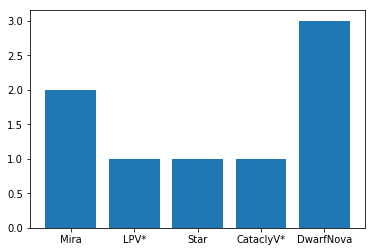

In [485]:
objects = ['Mira','LPV*','Star','CataclyV*','DwarfNova']
number = [2,1,1,1,3]
Y = range(len(number))
plt.bar(Y, number)
plt.xticks(Y,objects)
plt.savefig('/home/mj1e16/thesisFigures/objecttypesSimbad.png')
plt.show()

In [377]:
5./3600

0.001388888888888889

In [93]:
indexes = [i for i in range(10000)]
rtindexes = [i for i in range(len(result_table))]
tabMini = tabTot[0:10000]
tabMini['index'] = indexes
result_table['index'] = rtindexes
df = tabMini.to_pandas()
bigdf = result_table.to_pandas()

In [100]:
match = findMatchesNoCondition(tabMini,result_table,df,bigdf)

In [105]:
match[1]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213

In [104]:
match[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


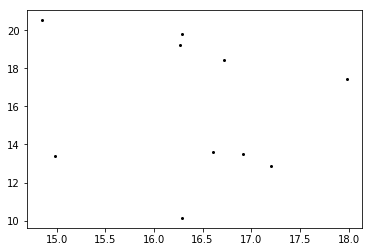

In [112]:
keplerMag = match[0]['MAG_BEST']
gaiaMag = match[1]['phot_g_mean_mag']
plt.plot(keplerMag[0:10],gaiaMag[0:10],'ko',markersize=2)
plt.show()

In [110]:
match[0][0:10]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


In [111]:
match[1][0:10]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213